### **Step 1 : Setting the initial value**

In [46]:
import os

import random

import pandas as pd

import matplotlib.pyplot as plt


In [45]:
from tensorflow import keras
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Step 2 : Building the CNN model**

* **新增了 Dropout 以及 L2regularization 技術，以避免 overfitting**

In [20]:
'''
Create a convolutional neural network model(CNN) :
With one separate input layer, three convolutional layers and a maximum pooling layer
'''

model = Sequential()

model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Flattenning 3D feature maps into 1D vectors
model.add(Flatten())

# Add full connectivity layer
model.add(Dense(512, activation='relu'))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a fully connected layer and apply L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))

# Output layer, outputs classification results(there are 15 dog breed categories)
model.add(Dense(15, activation='softmax'))

# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Printed Model Structures
# model.summary()
#return model

### **Step 3 : Training the CNN model and using valid set to test it**

* **優化 Learning Rate 的部分，以增加準確率**
* **使用 `ImageDataGenerator()` 產生額外的影像資料作訓練，以避免 overfitting 以及增加準確率**


In [22]:
learning_rate_function = ReduceLROnPlateau(monitor='val_accuracy',
                patience=3,
                verbose=1,
                factor=0.5,
                min_lr=0.00001)

In [23]:
#def train(train_dir, valid_dir, batch_size, epochs):

train_dir = '/content/drive/MyDrive/archive/train'
valid_dir = '/content/drive/MyDrive/archive/valid'

batch_size = 100
epochs = 20

# Preprocessing and enhancement of training and validation data
train_datagen = ImageDataGenerator(
            rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Generating data streams for training and validation sets
train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical'
        )

valid_generator = valid_datagen.flow_from_directory(
            valid_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical'
        )

# Training the model
train_history = model.fit(
            train_generator,
            steps_per_epoch=min(train_generator.samples // batch_size, 150),
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=valid_generator.samples // batch_size,
            callbacks=[learning_rate_function]
        )


Found 1714 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Epoch 1/20
17/17 [==============================] - 24s 1s/step - loss: 3.1423 - accuracy: 0.0836 - val_loss: 3.0421 - val_accuracy: 0.0300 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 22s 1s/step - loss: 2.9484 - accuracy: 0.1078 - val_loss: 2.7818 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 22s 1s/step - loss: 2.6768 - accuracy: 0.1722 - val_loss: 2.5937 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 22s 1s/step - loss: 2.4464 - accuracy: 0.2280 - val_loss: 2.3888 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 23s 1s/step - loss: 2.3336 - accuracy: 0.2615 - val_loss: 2.1848 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 22s 1s/step - loss: 2.2160 - accuracy: 0.3005 - val_loss: 2.0856 - val_accuracy: 0.3200 - lr: 0.00

### **Step 4 : Showing the Valid set Accuracy**

> **從上次的48%進步至62%**

In [43]:
# Calculating accuracy
scores = model.evaluate(
            valid_generator, steps=valid_generator.samples // batch_size)
validation_accuracy = scores[1] * 100

print("\nValid set Accuracy: %.2f%%\n" % validation_accuracy)

1/1 [==============================] - 0s 439ms/step - loss: 1.0883 - accuracy: 0.6200

Valid set Accuracy: 62.00%



In [21]:
def show_train_history(train_history, train, validation):
  train_acc = train_history.history['accuracy']
  val_acc = train_history.history['val_accuracy']

  plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
  plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

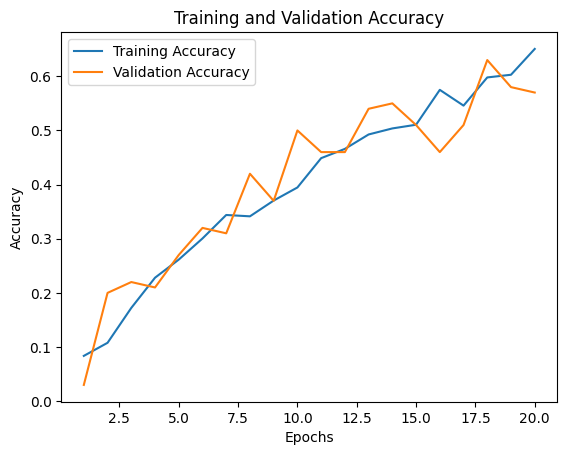

In [44]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

### **Step 5 : Using the testing_set to test my model**

* **改用`resize()`解決測試集影像大小與訓練集影像大小不一的問題，以提高 Test.xlsx 類別的平均程度**

In [26]:
def resize_image(img, target_size=(224, 224)):
    '''
    Resize image using bilinear interpolation method
    '''
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

    return resized_img

In [27]:
import cv2
from PIL import Image


In [28]:
def get_predicted_breed(predictions):
  '''
  To get the dog breed name based on the model predictions,
  assume that predictions is the result of the model's prediction of the image,
  determine the predicted breed based on the index of the highest probability in the probability vector
  '''

  class_names = ["Airedale", "Beagle", "Bloodhound", "Bluetick", "Chihuahua", "Collie", "Dingo",
                            "French Bulldog", "German Sheperd", "Malinois", "Newfoundland", "Pekinese",
                            "Pomeranian", "Pug", "Vizsla"]

  breed_index = predictions.argmax()
  breed_name = class_names[breed_index]

  return breed_name

In [29]:
#def test(test_dir):

test_dir = '/content/drive/MyDrive/archive/testing_set'

# Getting test set file address
test_files = os.listdir(test_dir)
# To be fair, the order of access is randomized.
random.shuffle(test_files)

test_results = []

for file_name in test_files:

  # Load image with center crop and preprocessing
  img_path = os.path.join(test_dir, file_name)
  img = Image.open(img_path)
  img_array = img_to_array(img)

  # resize
  img_array = resize_image(img_array, target_size=(224, 224))
  img_array = preprocess_input(img_array)
  img_array = img_array.reshape((1,) + img_array.shape)

  # Making predictions about the image
  predictions = model.predict(img_array)
  predicted_breed = get_predicted_breed(predictions)

  test_results.append((file_name, predicted_breed))

  # Output results into Excel(no need title)
  df = pd.DataFrame(test_results, columns=[
                        'File Name', 'Predicted Breed'])
  df.to_excel('test_data.xlsx', index=False, header=False)

print("Test results saved to test_data.xlsx")

1/1 [==============================] - 0s 21ms/step
Test results saved to test_data.xlsx
